Description:
* Exploring and analyzing a time series dataset about stocks
* 2 Datasets: QQQ and SPY daily stock info from late 90s to 4/10/2024
* Columns include: date, open, high, low, close, volume, and simple moving averages (5, 10, 20, 50, 100, 200 day)
* Will be using linear regression and other methods to try and predict future prices 

In [5]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Simple Linear Regression (OLS)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# Optimizing model parameters
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.ensemble import RandomForestRegressor

In [6]:
qqq = pd.read_csv('data\QQQ_1D_6sma_Jul24.csv')
# spy = pd.read_csv('data\SPY_1D_6sma.csv') # For now, only working on QQQ dataset

new_names = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
to_rename = ['MA', 'MA.1', 'MA.2', 'MA.3', 'MA.4', 'MA.5']

qqq.rename(columns = dict(zip(to_rename, new_names)), inplace = True)
# spy.rename(columns = dict(zip(to_rename, new_names)), inplace = True)

qqq.head()

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,NaN,NaN,NaN,NaN,NaN,NaN,5232202
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,NaN,NaN,NaN,NaN,NaN,NaN,9688602
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,NaN,NaN,NaN,NaN,NaN,NaN,8743602
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,NaN,NaN,NaN,NaN,NaN,NaN,6369000
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,NaN,NaN,NaN,NaN,NaN,51.175,4905800


# General EDA

In [7]:
# Check for nulls
qqq.isna().any(axis = None)

True

In [37]:
# Trying to plot the monthly performance over time
# Need to group by the month in to have a more legible plot

# Convert to datetime so it is more malleable
qqq.time = pd.to_datetime(qqq.time)
# spy.time = pd.to_datetime(spy.time)

# Grouping by last trading day of the month
qqq_monthly = qqq.groupby(qqq['time'].dt.to_period('M')).last()
# spy_monthly = spy.groupby(spy['time'].dt.to_period('M')).last()

qqq_monthly

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume,sma_5_1D_slope,sma_10_1D_slope,sma_20_1D_slope,sma_50_1D_slope,sma_100_1D_slope,sma_200_1D_slope,range_hi_lo,range_%close
time,,,,,,,,,,,,,,,,,,,,
1999-03,1999-03-31,54.125000,54.18750,52.31250,52.46875,NaN,NaN,NaN,NaN,51.706250,52.681250,8256602,NaN,NaN,NaN,NaN,0.090625,0.400000,1.87500,0.035736
1999-04,1999-04-30,54.125000,54.40625,51.81250,53.71875,NaN,NaN,NaN,54.116016,53.646093,54.642187,15295204,NaN,NaN,NaN,0.007812,0.175000,-0.318750,2.59375,0.048284
1999-05,1999-05-28,51.500000,52.31250,50.84375,52.03125,NaN,NaN,53.247656,53.100000,52.543749,51.165625,12969796,NaN,NaN,-0.010625,-0.084375,-0.137500,-0.168750,1.46875,0.028228
1999-06,1999-06-30,56.804685,59.93750,56.13281,57.62500,NaN,NaN,53.635937,54.045702,55.725781,55.960937,19467602,NaN,NaN,0.139375,0.294531,0.341406,0.351563,3.80469,0.066025
1999-07,1999-07-30,57.125000,57.75000,56.50781,56.59375,NaN,54.366172,55.526093,58.634765,57.678124,56.892187,10947398,NaN,NaN,0.034375,-0.071094,-0.478125,-0.137500,1.24219,0.021949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,2024-03-28,444.780000,445.64000,443.65000,444.01000,390.88125,414.385000,434.104600,441.614500,442.291000,444.660000,36839641,0.41760,0.8057,0.736000,0.250500,0.487000,-0.372000,1.99000,0.004482
2024-04,2024-04-30,431.150000,432.56000,424.51000,424.59000,398.05165,425.250600,436.531000,431.600000,424.709000,427.860000,43665934,0.22760,0.3730,-0.119600,-0.826000,-0.651000,-0.096000,8.05000,0.018959
2024-05,2024-05-31,451.780000,452.48000,443.05500,450.71000,405.83795,435.028500,440.338000,449.062500,454.817000,455.266000,55941301,0.42145,0.4576,0.138800,1.190500,-0.127000,-0.590000,9.42500,0.020911


In [12]:
print(f'QQQ\n{qqq.describe()}')
# print('\n\nSpy')
# print(spy.describe())

QQQ
                                time         open         high          low  \
count                           6377  6377.000000  6377.000000  6377.000000   
mean   2011-11-09 09:28:08.505566976   119.621249   120.591434   118.554110   
min              1999-03-10 00:00:00    19.940000    20.530000    19.759990   
25%              2005-07-12 00:00:00    42.170000    42.670000    41.789990   
50%              2011-11-07 00:00:00    67.600010    68.080000    67.070010   
75%              2018-03-12 00:00:00   161.290000   162.770000   159.909600   
max              2024-07-12 00:00:00   503.070000   503.520000   498.390000   
std                              NaN   109.858174   110.625841   109.045528   

             close        sma_5       sma_10       sma_20       sma_50  \
count  6377.000000  6178.000000  6278.000000  6328.000000  6358.000000   
mean    119.632760   115.465560   117.469049   118.510106   119.181223   
min      20.060000    24.604750    23.600400    22.701400    2

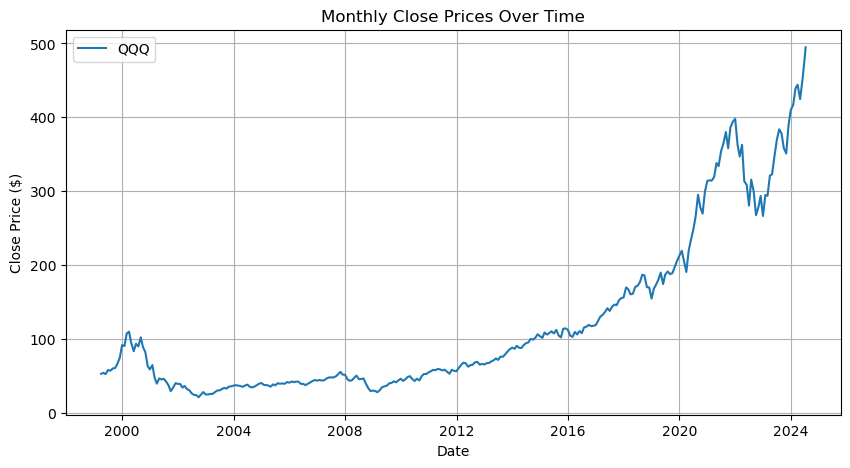

In [35]:
# Plotting the performance over time

plt.figure(figsize = (10,5))

plt.plot(qqq_monthly['time'], qqq_monthly['close'], label = 'QQQ')
# plt.plot(spy_monthly['time'], spy_monthly['close'], label = 'SPY')
plt.title('Monthly Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.legend()

plt.show()

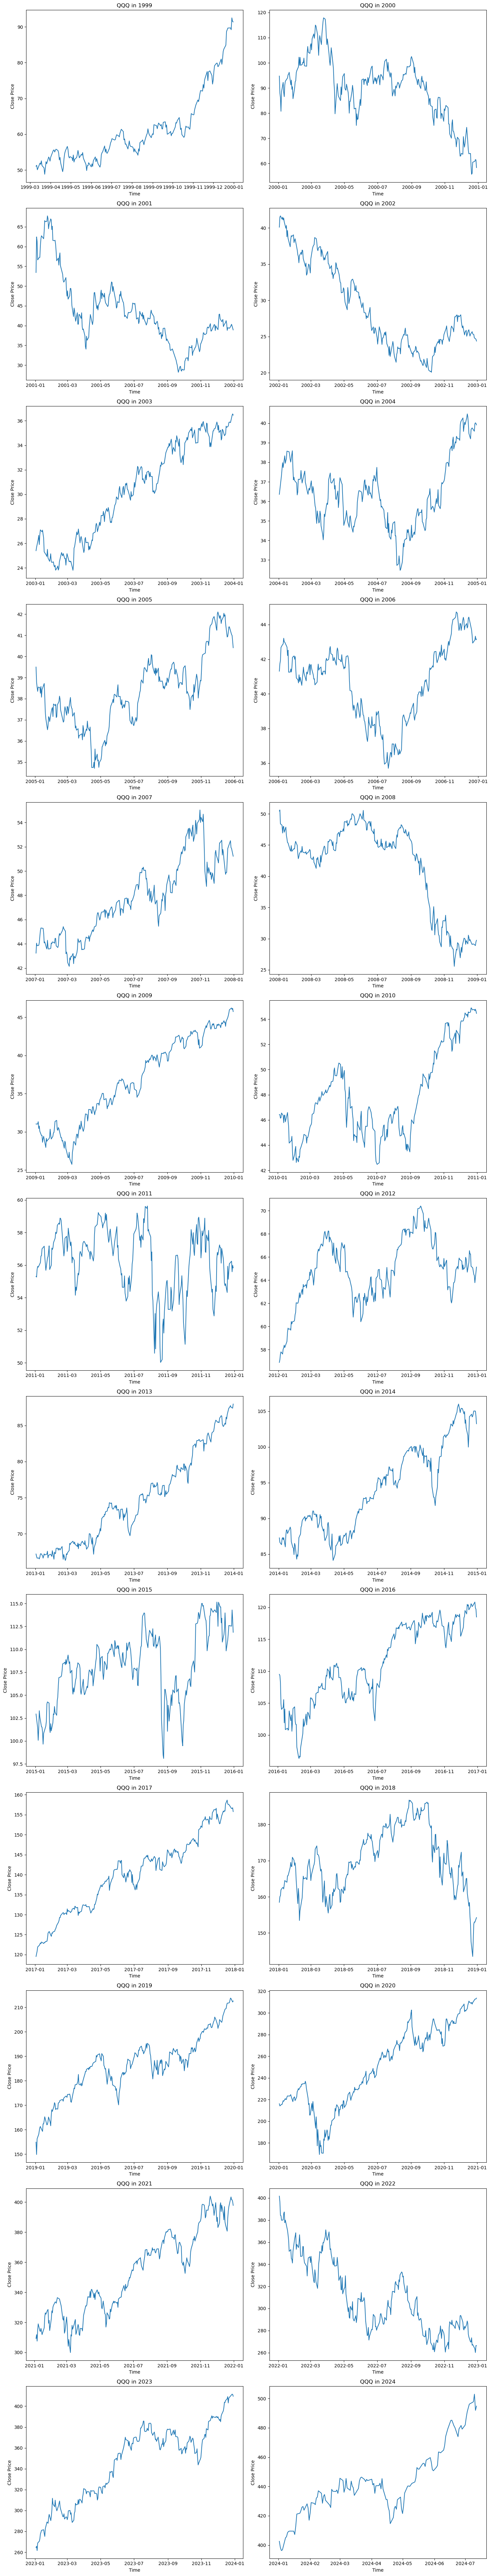

In [81]:
# Plotting the performance over time - annual
qqq_years = qqq.copy()
qqq_years['Year'] = qqq_years['time'].dt.year
years = qqq_years['Year'].unique()

nrows = len(years) // 2 + len(years) % 2
fig, axs = plt.subplots(nrows, 2, figsize = (15, 6*nrows))

for i, year in enumerate(years):
    curr_year = qqq_years[qqq_years.Year == year].sort_values('time')
    row = i // 2
    col = i % 2
    axs[row, col].plot(curr_year.time, curr_year.close)
    axs[row, col].set_title(f'QQQ in {year}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Close Price')

fig.tight_layout()
plt.show()

In [119]:
# Monthly change
qqq_mChange_dates = qqq.loc[qqq.groupby(pd.Grouper(key = 'time', freq = 'ME'))['time'].agg(['idxmin','idxmax']).stack()]
qqq_mChange = qqq_mChange_dates.groupby(pd.Grouper(key = 'time', freq = 'ME'))['close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])
qqq_mChange

time
1999-03-31    0.027540
1999-04-30    0.002917
1999-05-31   -0.026316
1999-06-30    0.132678
1999-07-31   -0.024508
                ...   
2024-03-31   -0.003591
2024-04-30   -0.045758
2024-05-31    0.069249
2024-06-30    0.057335
2024-07-31    0.026768
Freq: ME, Name: close, Length: 305, dtype: float64

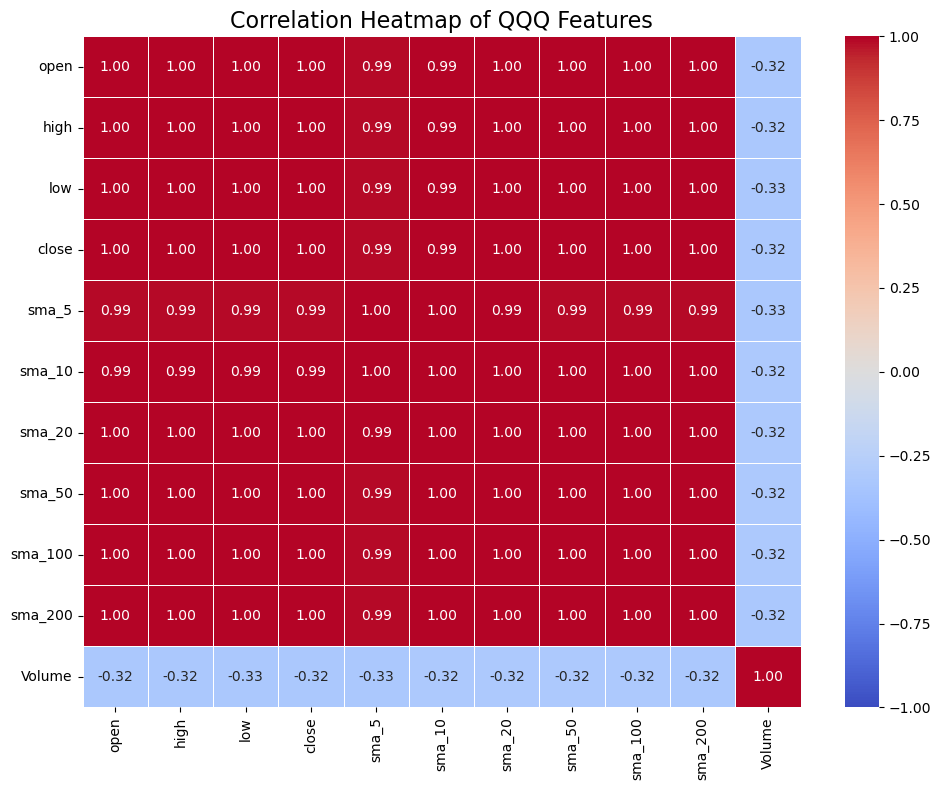

In [16]:
qqq_corr = qqq.drop(columns = ['time']).corr()

plt.figure(figsize=(10,8))
sns.heatmap(qqq_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Features', fontsize=16)

plt.tight_layout()
plt.show()

# Majority of the features (OHLC and SMAs) are highly correlated with one another -> contextually, they all represent the same thing: price
#  This does not mean they are still not significant, but statistically, this a mess

# Feature Engineering

In [18]:
qqq.columns

Index(['time', 'open', 'high', 'low', 'close', 'sma_5', 'sma_10', 'sma_20',
       'sma_50', 'sma_100', 'sma_200', 'Volume'],
      dtype='object')

In [22]:
# Translate datetime data into a numeric data type
# qqq['days_since_start'] = (qqq['time'] - qqq['time'].min()).dt.days
# spy['days_since_start'] = (spy['time'] - spy['time'].min()).dt.days
def create_feats(df):  
    # Slope of sma
    sma_cols = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
    for sma in sma_cols:
        df[sma + '_1D_slope'] = df[sma].diff()
    # Range between high and low - volatlity in the price swings
    df['range_hi_lo'] = df['high'] - df['low']
    # range as a percentage of the close
    df['range_%close'] = df['range_hi_lo']/df['close']
    return(df)

create_feats(qqq)

In [24]:
# Lagged Values
#  Using lagged values because you will never have the prediction periods' independent values
qqq_lag = qqq.copy()

lag_periods = [1, 5, 10, 20]
for col in ['open', 'high', 'low', 'close', 'Volume', 
            'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200',
            'sma_5_1D_slope', 'sma_10_1D_slope', 'sma_20_1D_slope', 'sma_50_1D_slope', 'sma_100_1D_slope', 'sma_200_1D_slope', 
            'range_hi_lo', 'range_%close']:
    for lag in lag_periods:
        qqq_lag[f'{col}_lag_{lag}'] = qqq[col].shift(lag)
# qqq_lag = qqq_lag.fillna(0)
qqq_lag = qqq_lag.dropna()
qqq_lag

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,...,sma_200_1D_slope_lag_10,sma_200_1D_slope_lag_20,range_hi_lo_lag_1,range_hi_lo_lag_5,range_hi_lo_lag_10,range_hi_lo_lag_20,range_%close_lag_1,range_%close_lag_5,range_%close_lag_10,range_%close_lag_20
220,2000-01-21,96.5000,96.562500,95.06250,96.25000,64.128593,72.821797,83.103281,90.706640,92.053125,...,-2.150000,1.63125,2.867190,4.421875,8.000000,1.87500,0.030023,0.048459,0.099071,0.021030
221,2000-01-24,97.4375,97.625000,90.96875,91.25000,64.305781,73.137422,83.528281,90.786328,92.328125,...,-0.575000,1.30625,1.500000,1.625000,6.000000,1.75000,0.015584,0.017532,0.067797,0.019519
222,2000-01-25,91.8750,94.117185,89.40625,93.15625,64.494375,73.467812,83.966406,90.959765,92.418750,...,-0.500000,1.18125,6.656250,3.000000,4.000000,5.66406,0.072945,0.031915,0.043360,0.063153
223,2000-01-26,93.2500,93.312500,89.00000,89.50000,64.668437,73.763750,84.312656,90.975390,92.543750,...,0.048438,0.86250,4.710935,3.570315,5.875000,1.93750,0.050570,0.037471,0.066572,0.021724
224,2000-01-27,91.7500,92.500000,87.62500,90.50000,64.856875,74.042187,84.681719,90.875390,92.937500,...,0.075000,0.76250,4.312500,2.867190,3.242185,2.62500,0.048184,0.030023,0.037455,0.028378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6372,2024-07-08,496.5300,497.895000,495.50000,497.34000,418.613850,448.231300,459.650400,480.283000,484.787000,...,0.692000,2.36400,5.010000,8.740000,3.865000,2.35000,0.010098,0.018242,0.008049,0.005072
6373,2024-07-09,498.8700,500.000000,496.24000,497.77000,419.280000,448.923500,461.116800,482.023500,487.168000,...,-1.046000,2.45000,2.395000,6.235000,6.110000,3.90000,0.004816,0.012938,0.012891,0.008424
6374,2024-07-10,499.7100,503.520000,498.39000,502.96000,420.005500,449.620900,462.556000,483.930000,489.526000,...,-1.136000,2.34000,3.760000,6.760000,4.560000,3.66000,0.007554,0.013881,0.009512,0.007874
6375,2024-07-11,503.0700,503.280000,490.72500,491.93000,420.675600,450.195100,463.739600,485.125500,490.682000,...,-0.968000,2.73000,5.130000,4.950000,2.790000,6.11000,0.010200,0.010081,0.005808,0.013055


## Variance Inflation Factor & Correlation

In [100]:
# https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select numerical columns for VIF analysis
numerical_cols = qqq_lag.select_dtypes(include=[np.number]).columns
X = qqq_lag[numerical_cols].drop('close', axis=1)  # Exclude the target variable
X = add_constant(X)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values('VIF', ascending=False)

vif[vif.VIF == np.inf]

# The VIF seems to be incredibly high for almost all features --> earlier we saw that all price derived features were essentially 1, so this makes sense

C:\Coding\IDE\Anaconda\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
47,sma_20_lag_1,inf
39,sma_5_lag_1,inf
57,sma_100_lag_10,inf
29,low_lag_10,inf
30,low_lag_20,inf
76,sma_50_1D_slope_lag_5,inf
32,close_lag_5,inf
33,close_lag_10,inf
34,close_lag_20,inf
88,range_hi_lo_lag_5,inf


### Correlation Matrices

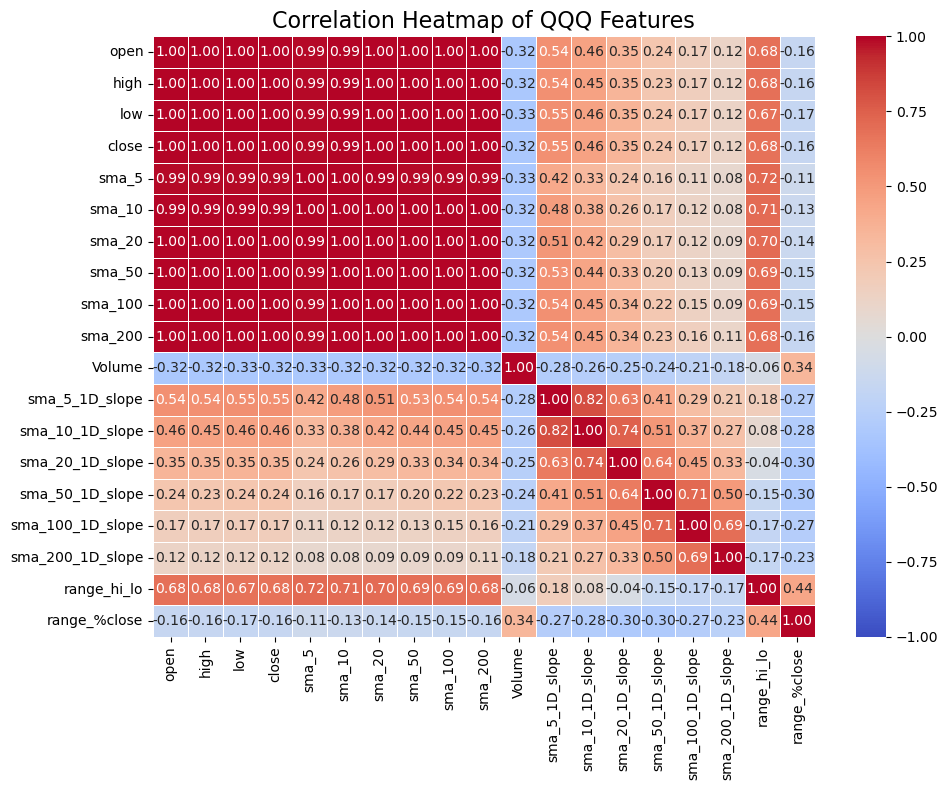

In [102]:
# Engineered features correlation
qqq_feat_corr = qqq.drop(columns = ['time']).corr()

plt.figure(figsize=(10,8))
sns.heatmap(qqq_feat_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Features', fontsize=16)

plt.tight_layout()
plt.show()

#### Base vs Lag

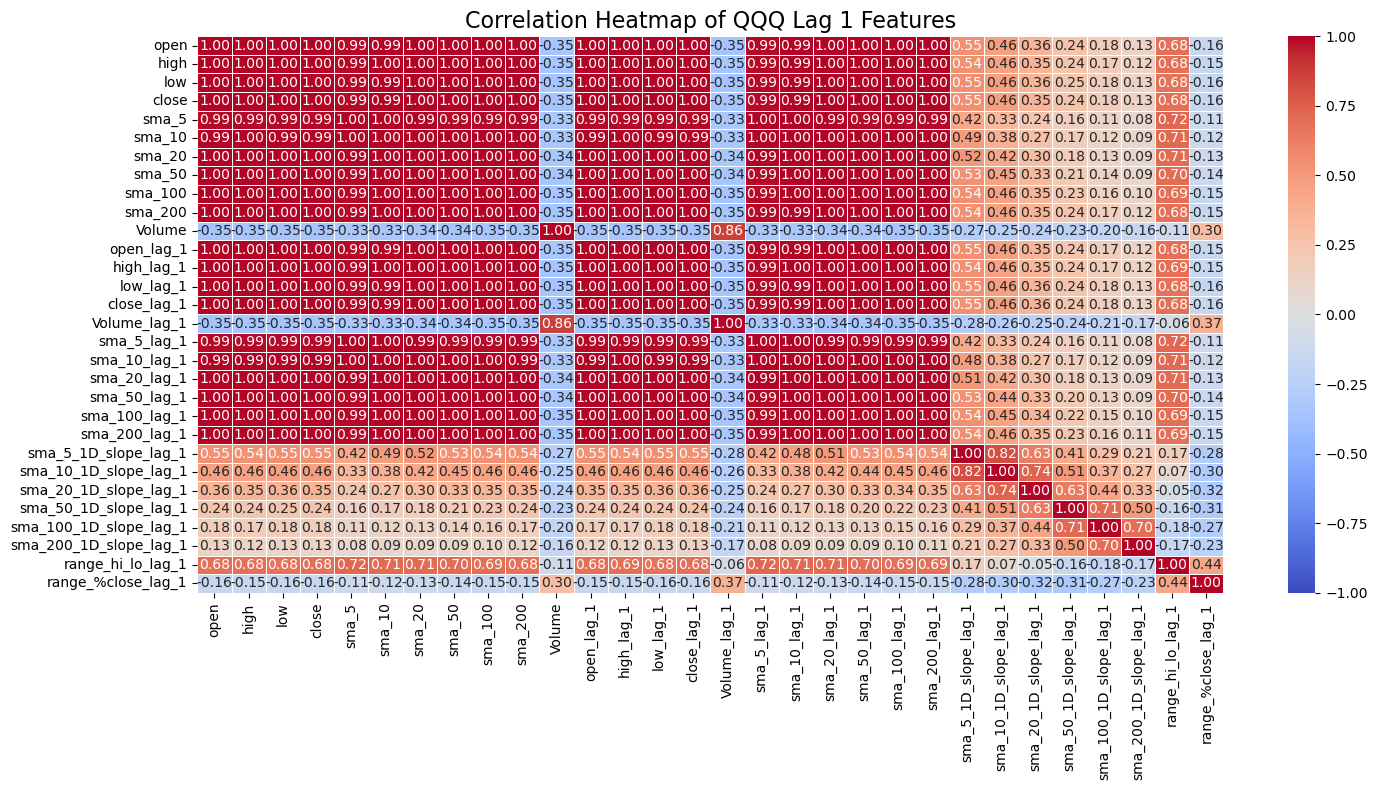

In [140]:
# Lagged features correlation - base vs lag period
qqq_lag_corr = qqq_lag.drop(columns = ['time']).corr()
base_cols = ['open', 'high', 'low', 'close', 'sma_5', 'sma_10', 'sma_20',
             'sma_50', 'sma_100', 'sma_200', 'Volume']
lag1_cols = base_cols + [col for col in qqq_lag.columns if 'lag_1' in col and 'lag_10' not in col]
lag5_cols = base_cols + [col for col in qqq_lag.columns if 'lag_5' in col]
lag10_cols = base_cols +[col for col in qqq_lag.columns if 'lag_10' in col]
lag20_cols = base_cols +[col for col in qqq_lag.columns if 'lag_20' in col]

qqq_lag1_corr = qqq_lag[lag1_cols].corr()
qqq_lag5_corr = qqq_lag[lag5_cols].corr()
qqq_lag10_corr = qqq_lag[lag10_cols].corr()
qqq_lag20_corr = qqq_lag[lag20_cols].corr()

plt.figure(figsize=(15, 8))

sns.heatmap(qqq_lag1_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Lag 1 Features', fontsize=16)
plt.tight_layout()
plt.show()

# All the lag periods compared to the base features have the same correlation output

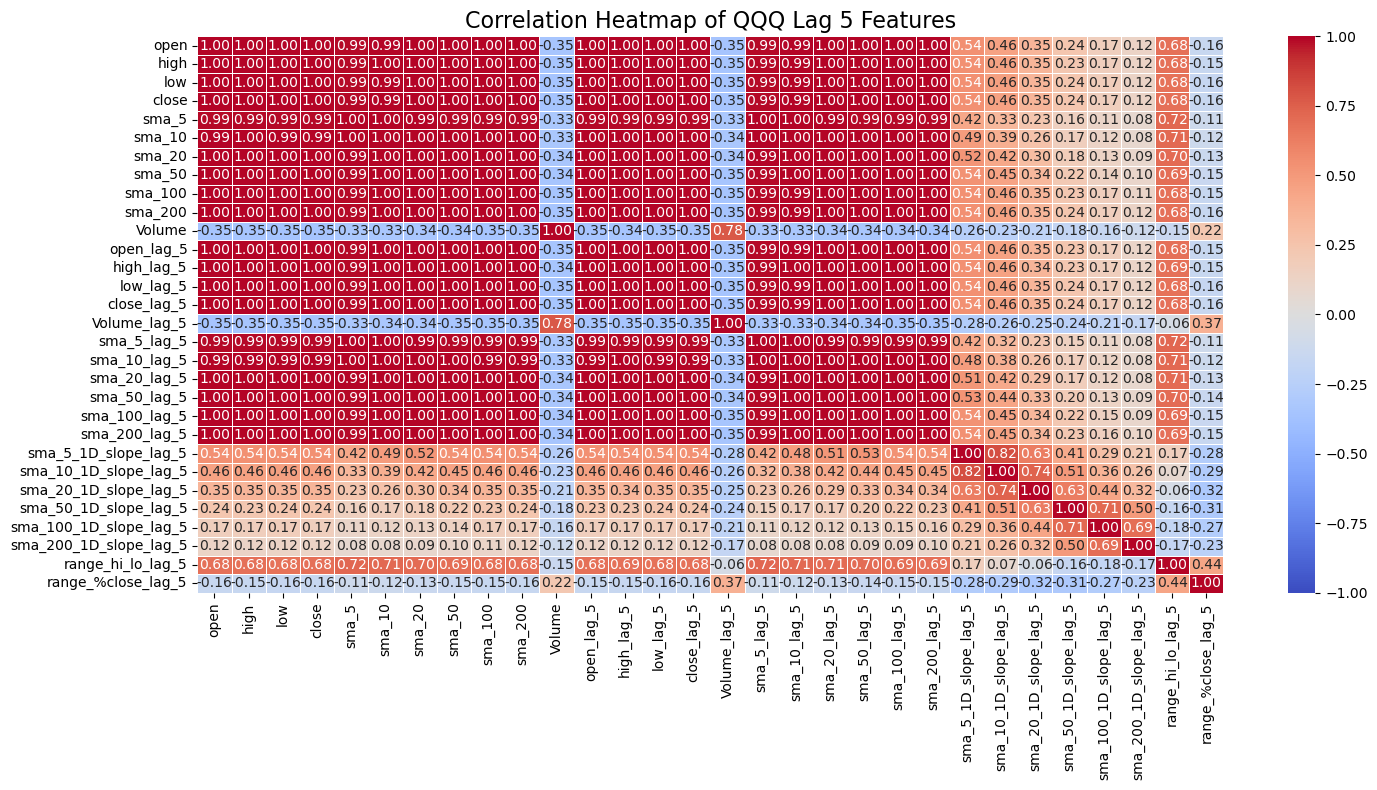

In [145]:
plt.figure(figsize=(15, 8))

sns.heatmap(qqq_lag5_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Lag 5 Features', fontsize=16)
plt.tight_layout()
plt.show()

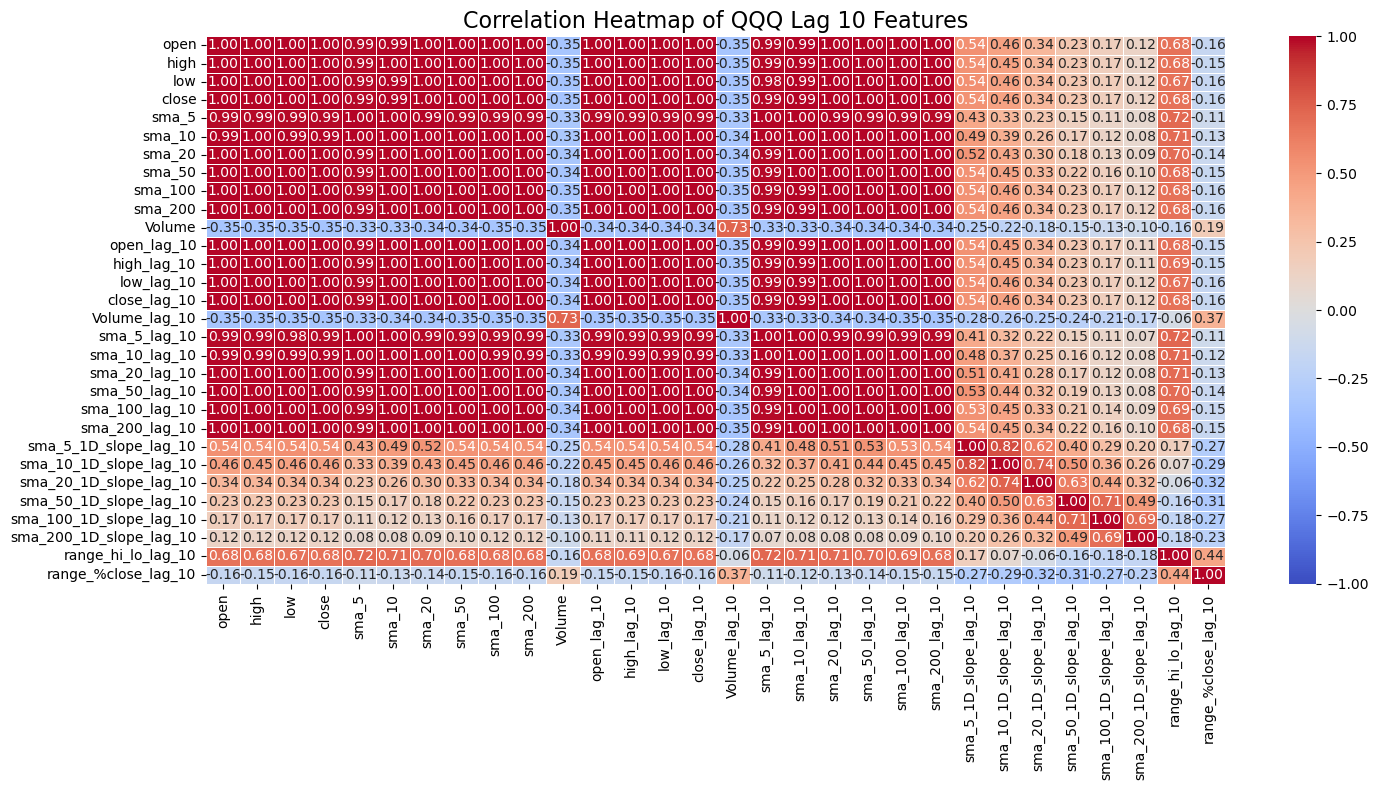

In [147]:
plt.figure(figsize=(15, 8))

sns.heatmap(qqq_lag10_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Lag 10 Features', fontsize=16)
plt.tight_layout()
plt.show()

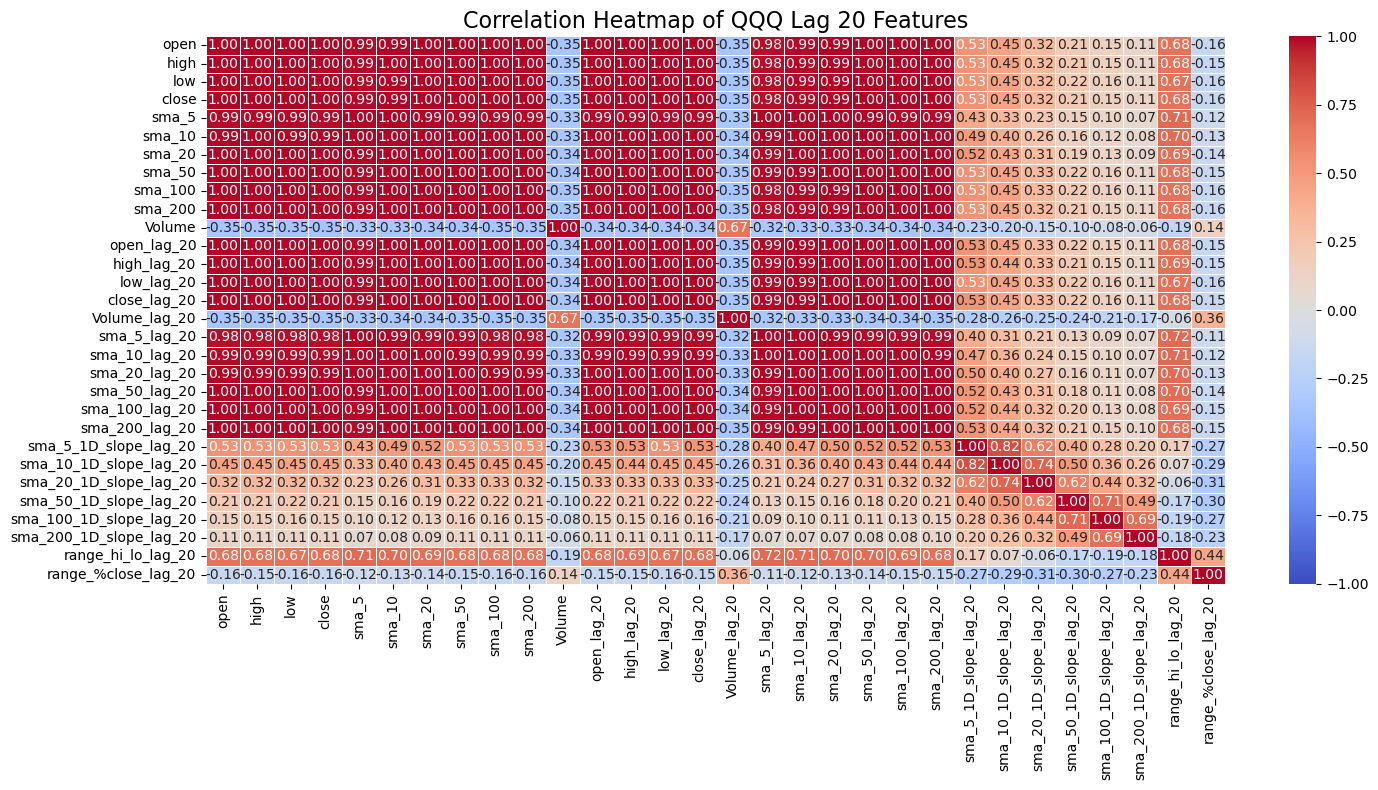

In [149]:
plt.figure(figsize=(15, 8))

sns.heatmap(qqq_lag20_corr, cmap='coolwarm', vmin = -1, vmax = 1, center = 0, linewidths=0.5, fmt='.2f',  annot=True)
plt.title('Correlation Heatmap of QQQ Lag 20 Features', fontsize=16)
plt.tight_layout()
plt.show()

#### Features vs Lagged Features

# Model - linear regression

In [26]:
qqq_lag1_base = qqq_lag[['time', 'close', 'open_lag_1', 'high_lag_1', 'low_lag_1', 'close_lag_1', 'Volume_lag_1']]
qqq_lag1_sma = qqq_lag[['time', 'close', 'open_lag_1', 'high_lag_1', 'low_lag_1', 'close_lag_1', 'Volume_lag_1',
                       'sma_5_lag_1', 'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1']]

# Model - Ensemble: Random Forest Regressor

In [284]:
# train test split 80/20

qqq_x_train, qqq_x_test, qqq_y_train, qqq_y_test = train_test_split(qqq, qqq.close, test_size = 0.2)
spy_x_train, spy_x_test, spy_y_train, spy_y_test = train_test_split(spy, spy.close, test_size = 0.2)

In [233]:
start = time.time()

def clf_performance(regressor, model_name): # Borrowing from Ken Jee
    print(f"\n{model_name}")
    print('Best Score: ' + str(regressor.best_score_))
    print('Best Parameters: ' + str(regressor.best_params_))

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 250, 500, 750, 1000],
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50, 75, 100, None],
    'max_features': ['log2', 'sqrt', 10, 50, 100, 200, 300],
    'min_samples_leaf': [1, 2, 4, 10],
    'min_samples_split': [2, 5, 10]
}

clf_rf_rnd = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=200, cv=5, verbose=True, n_jobs=-1)
best_clf_rf_rnd = clf_rf_rnd.fit(qqq_x_train, qqq_y_train)
clf_performance(best_clf_rf_rnd, 'Random Forest Regressor')

end = time.time()
print(f'Total time elapse: {end - start}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Random Forest Regressor
Best Score: 0.99986980704629
Best Parameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 100, 'bootstrap': True}
Total time elapse: 1411.8825869560242


In [292]:
start = time.time()

qqq_rfreg = RandomForestRegressor(n_estimators = 250, min_samples_split= 2, min_samples_leaf= 1, max_features= 10, max_depth= 100, bootstrap= True)
spy_rfreg = RandomForestRegressor(n_estimators = 250, min_samples_split= 2, min_samples_leaf= 1, max_features= 10, max_depth= 100, bootstrap= True)

# training on all columns except target column (close) and the time column (converted it to a continuous variable: days_since_start)
feature_cols = [col for col in qqq.columns if col != 'close' and col != 'time']

qqq_rfreg.fit(qqq_x_train[feature_cols], qqq_y_train)
spy_rfreg.fit(spy_x_train[feature_cols], spy_y_train)

# Creating a dataframe for evaluation and graphing purposes
qqq_rfreg_test = qqq_x_test.copy()
qqq_rfreg_test['predict_close'] = qqq_rfreg.predict(qqq_x_test[feature_cols])

spy_rfreg_test = spy_x_test.copy()
spy_rfreg_test['predict_close'] = spy_rfreg.predict(spy_x_test[feature_cols])

# Model evaluation
qqq_rfreg_mse = mean_squared_error(qqq_rfreg_test['close'], qqq_rfreg_test['predict_close'])
qqq_rfreg_r2 = r2_score(qqq_rfreg_test['close'], qqq_rfreg_test['predict_close'])

spy_rfreg_mse = mean_squared_error(spy_rfreg_test['close'], spy_rfreg_test['predict_close'])
spy_rfreg_r2 = r2_score(spy_rfreg_test['close'], spy_rfreg_test['predict_close'])

print(f'Random Forest Regressor')
print(f'\nQQQ Mean Squared Error:{qqq_rfreg_mse}\nQQQ R squared: {qqq_rfreg_r2}')
print(f'\nSPY Mean Squared Error:{spy_rfreg_mse}\nSPY R squared: {spy_rfreg_r2}')

end = time.time()
print(f'\nTotal time elapse: {(end - start)/60} min')

Random Forest Regressor

QQQ Mean Squared Error:1.347199336568001
QQQ R squared: 0.9998825327504284

SPY Mean Squared Error:1.3718028541270102
SPY R squared: 0.9998890978863509

Total time elapse: 0.3812063455581665 min


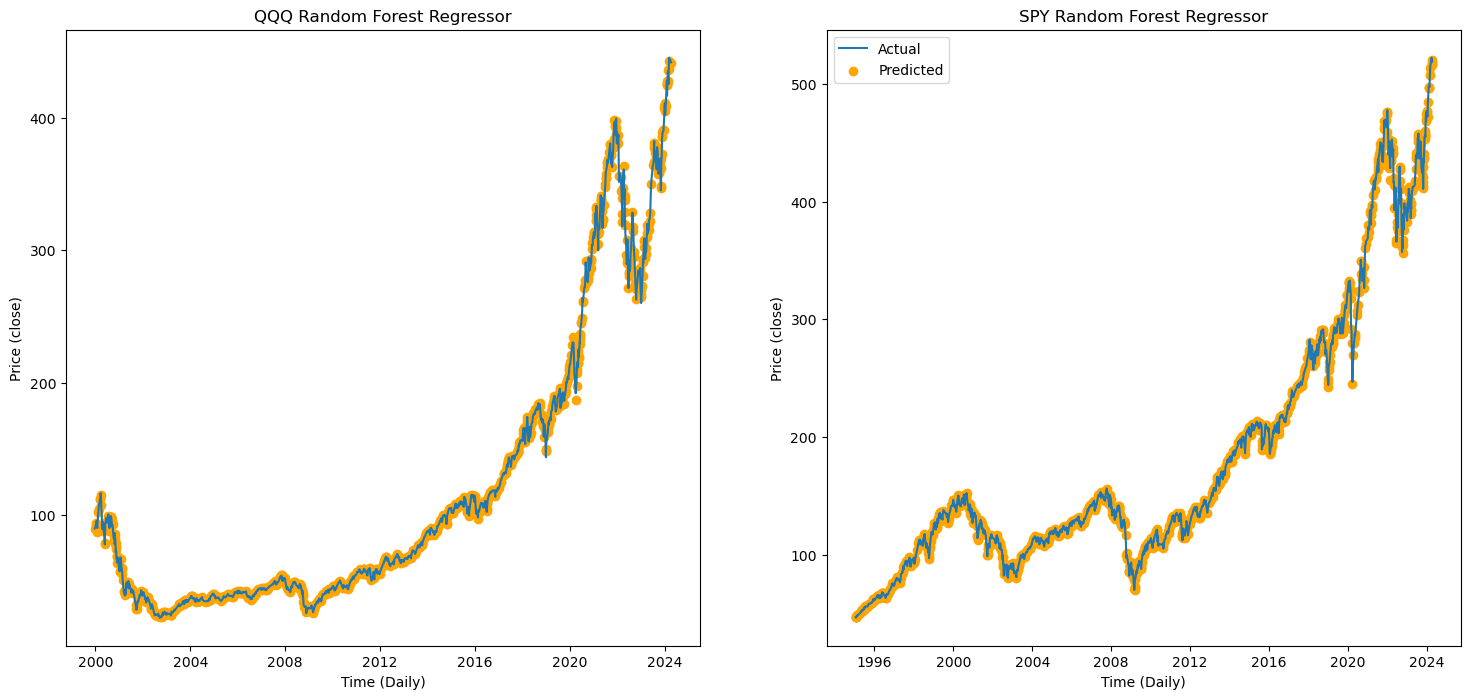

In [310]:
qqq_rfreg_test = qqq_rfreg_test.sort_values('time')
spy_rfreg_test = spy_rfreg_test.sort_values('time')

fig, axs = plt.subplots(1,2)

axs[0].plot(qqq_rfreg_test['time'], qqq_rfreg_test['close'], label = 'Actual')
axs[0].scatter(qqq_rfreg_test['time'], qqq_rfreg_test['predict_close'], color = 'orange', label = 'Predicted')
axs[1].plot(spy_rfreg_test['time'], spy_rfreg_test['close'], label = 'Actual')
axs[1].scatter(spy_rfreg_test['time'], spy_rfreg_test['predict_close'], color = 'orange', label = 'Predicted')

axs[0].set_xlabel('Time (Daily)')
axs[0].set_ylabel('Price (close)')
axs[0].set_title('QQQ Random Forest Regressor')

axs[1].set_xlabel('Time (Daily)')
axs[1].set_ylabel('Price (close)')
axs[1].set_title('SPY Random Forest Regressor')

plt.legend()

fig.set_figheight(8)
fig.set_figwidth(18)

# Model - Gradient Boosting (XGBoost)

# Model - Support Vector Machines

# Model - LSTM network

# Model - GRU

# Model - CNN 